# Improved Regularization of Convolutional Neural Networks (Step-1default)

## 1. Resnet-20

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

In [ ]:
def _weights_init(m):
    """
        Initialization of CNN weights
    """
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet20(nn.Module):
    def __init__(self):
        super(ResNet20, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.layer1 = self.blocks(16, 16, 3, stride=1)
        self.layer2 = self.blocks(16, 32, 3, stride=2)
        self.layer3 = self.blocks(32, 64, 3, stride=2)
        self.fc = nn.Linear(64, 10)
        self.apply(_weights_init)

    def blocks(self, in_channels, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for i in strides:
            layers.append(ResidualBlock(in_channels, out_channels, i))
            in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

## 2. Data Processing

In [ ]:
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader


normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                     std=[0.2023, 0.1994, 0.2010])


train_loader = DataLoader(
        datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=128, shuffle=True,
        num_workers=4, pin_memory=True)

val_loader = DataLoader(
        datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=128, shuffle=False,
        num_workers=4, pin_memory=True)



100%|██████████| 170498071/170498071 [00:13<00:00, 12305197.58it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 3. Model Training

In [ ]:
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResNet20().to(device)

INITIAL_LR = 0.1
MOMENTUM = 0.9
REG = 1e-4

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)

In [ ]:
import os
EPOCHS = 200
DECAY_EPOCHS = [60,120,160]
#DECAY_EPOCHS = [100,150]
DECAY = 0.1

CHECKPOINT_FOLDER = "./saved_model"

best_val_acc = 0
best_val_acc_loss = 0
train_accs=[]
train_losses=[]
val_accs=[]
val_losses=[]
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    if i in DECAY_EPOCHS:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)

    model.train()
    print("Epoch %d:" %i)
    total_examples = 0
    correct_examples = 0
    train_loss = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_examples += targets.size(0)
        correct_examples += predicted.eq(targets).sum().item()


    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
    train_accs.append(avg_acc)
    train_losses.append(avg_loss)



    model.eval()
    total_examples = 0
    correct_examples = 0

    val_loss = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += predicted.eq(targets).sum().item()

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    val_accs.append(avg_acc)
    val_losses.append(avg_loss)

    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        best_val_acc_loss = avg_loss
        if not os.path.exists(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': model.state_dict(),
                 'epoch': i,
                 'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'resnet.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f} with loss: {best_val_acc_loss:.4f}")

==> Training starts!
Epoch 0:
Training loss: 1.5722, Training accuracy: 0.4175
Validation loss: 1.2527, Validation accuracy: 0.5517
Saving ...

Epoch 1:
Training loss: 1.0627, Training accuracy: 0.6187
Validation loss: 1.0008, Validation accuracy: 0.6539
Saving ...

Epoch 2:
Training loss: 0.8429, Training accuracy: 0.7020
Validation loss: 0.7838, Validation accuracy: 0.7284
Saving ...

Epoch 3:
Training loss: 0.7164, Training accuracy: 0.7493
Validation loss: 1.1056, Validation accuracy: 0.6591

Epoch 4:
Training loss: 0.6470, Training accuracy: 0.7739
Validation loss: 0.7313, Validation accuracy: 0.7573
Saving ...

Epoch 5:
Training loss: 0.5927, Training accuracy: 0.7961
Validation loss: 0.6149, Validation accuracy: 0.7880
Saving ...

Epoch 6:
Training loss: 0.5517, Training accuracy: 0.8096
Validation loss: 0.7597, Validation accuracy: 0.7564

Epoch 7:
Training loss: 0.5226, Training accuracy: 0.8200
Validation loss: 0.6020, Validation accuracy: 0.7981
Saving ...

Epoch 8:
Training

## 4.

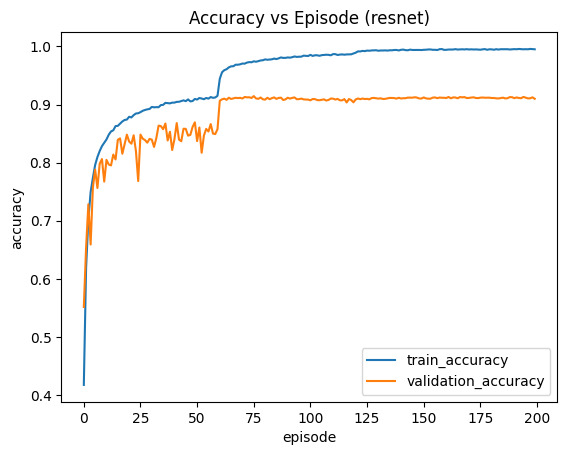

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(200),train_accs,label='train_accuracy')
plt.plot(range(200),val_accs,label='validation_accuracy')
plt.xlabel('episode')
plt.ylabel('accuracy')
plt.title('Accuracy vs Episode (resnet)')
plt.legend()
plt.show()

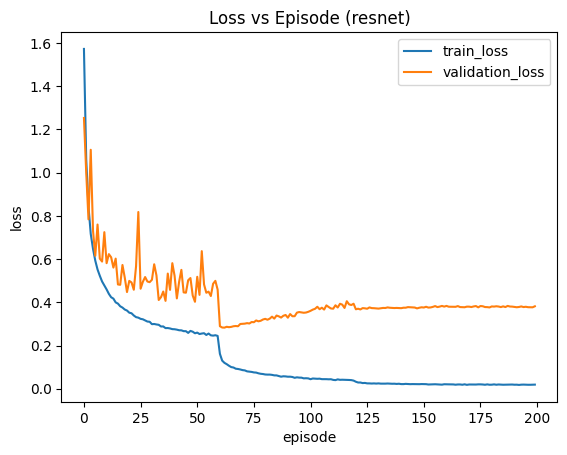

In [ ]:
plt.plot(range(200),train_losses,label='train_loss')
plt.plot(range(200),val_losses,label='validation_loss')
plt.xlabel('episode')
plt.ylabel('loss')
plt.title('Loss vs Episode (resnet)')
plt.legend()
plt.show()

In [ ]:
xr=[0.1,0.25,0.5,0.68,0.75,1]
yr=[0.9003,0.9013,0.9044,0.9066,0.9092,0.9023]
yrn=[0.9145 for i in range(6)]

xm=[0.1,0.15,0.2,0.4,1]
ym=[0.9206,0.9222,0.9252,0.9245,0.9242]
ymn=[0.9145 for i in range(5)]

xc1=[8,12,16,20,24]
yc1=[0.9236,0.9258,0.9262,0.9285,0.9232]
xc2=[8,12,16]
yc2=[0.9232,0.9280,0.9275]
ycn=[0.9145 for i in range(5)]

In [ ]:
import matplotlib.pyplot as plt

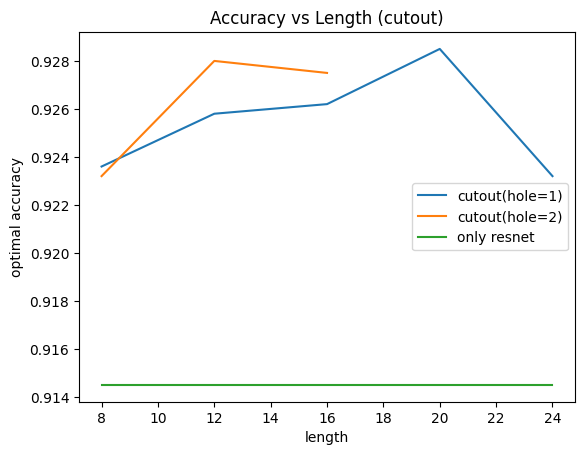

In [ ]:
plt.plot(xc1,yc1,label='cutout(hole=1)')
plt.plot(xc2,yc2,label='cutout(hole=2)')
plt.plot(xc1,ycn,label='only resnet')
plt.xlabel('length')
plt.ylabel('optimal accuracy')
plt.title('Accuracy vs Length (cutout)')
plt.legend()
plt.show()

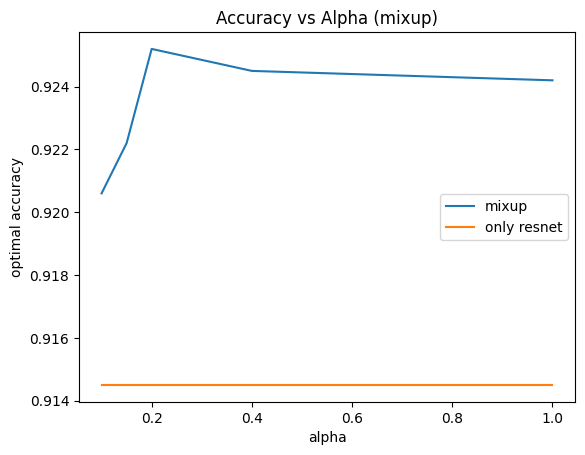

In [ ]:
plt.plot(xm,ym,label='mixup')
plt.plot(xm,ymn,label='only resnet')
plt.xlabel('alpha')
plt.ylabel('optimal accuracy')
plt.title('Accuracy vs Alpha (mixup)')
plt.legend()
plt.show()

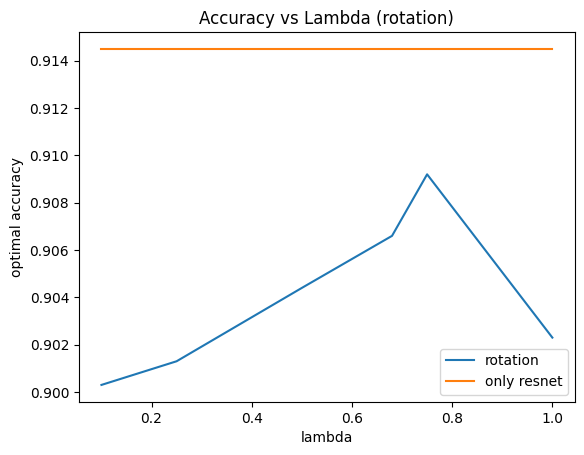

In [ ]:
plt.plot(xr,yr,label='rotation')
plt.plot(xr,yrn,label='only resnet')
plt.xlabel('lambda')
plt.ylabel('optimal accuracy')
plt.title('Accuracy vs Lambda (rotation)')
plt.legend()
plt.show()

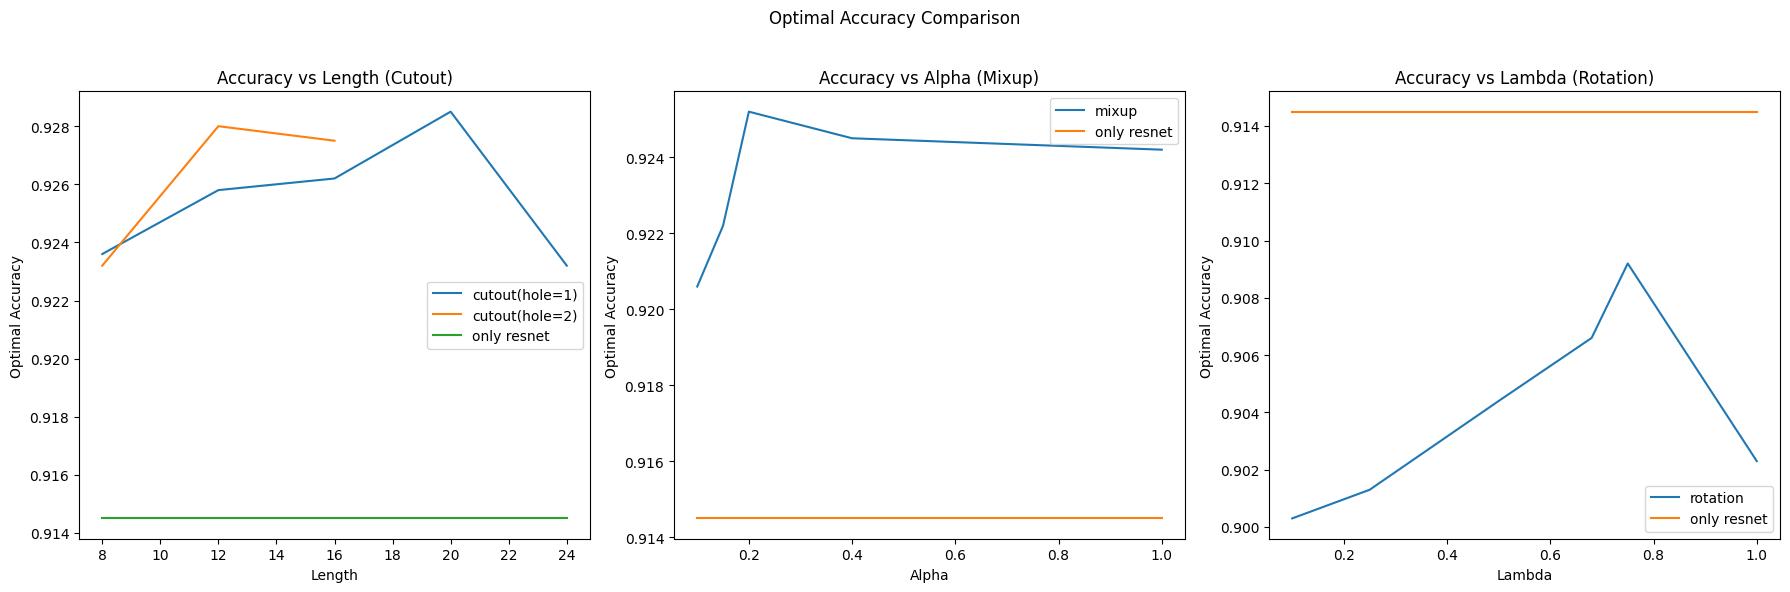

In [ ]:
import matplotlib.pyplot as plt

# Adjust figure size and layout
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot for Cutout
axs[0].plot(xc1, yc1, label='cutout(hole=1)')
axs[0].plot(xc2, yc2, label='cutout(hole=2)')
axs[0].plot(xc1, ycn, label='only resnet')
axs[0].set_xlabel('Length')
axs[0].set_ylabel('Optimal Accuracy')
axs[0].set_title('Accuracy vs Length (Cutout)')
axs[0].legend()

# Plot for Mixup
axs[1].plot(xm, ym, label='mixup')
axs[1].plot(xm, ymn, label='only resnet')
axs[1].set_xlabel('Alpha')
axs[1].set_ylabel('Optimal Accuracy')
axs[1].set_title('Accuracy vs Alpha (Mixup)')
axs[1].legend()

# Plot for Rotation
axs[2].plot(xr, yr, label='rotation')
axs[2].plot(xr, yrn, label='only resnet')
axs[2].set_xlabel('Lambda')
axs[2].set_ylabel('Optimal Accuracy')
axs[2].set_title('Accuracy vs Lambda (Rotation)')
axs[2].legend()

# Adjust overall layout
plt.suptitle('Optimal Accuracy Comparison')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the rectangle to prevent title overlap

# Show the plot
plt.show()
